# 📌 Diet Plan Prediction Model
This notebook trains a machine learning model to predict the best diet plan based on user attributes like age, weight, height, area, and preference. We'll explore the data, preprocess it, train models (Random Forest & XGBoost), optimize hyperparameters, and evaluate performance.

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Set plot style
sns.set_style("whitegrid")


## 📂 Load Dataset

In [3]:

# Load dataset
file_path = r'C:\Users\tanma\OneDrive\Desktop\apps\Personel\ML\NutriAi\diet_plan_large_dataset.csv'
df = pd.read_csv(file_path)

# Display dataset info
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Age         1000 non-null   int64 
 1   Weight      1000 non-null   int64 
 2   Height      1000 non-null   int64 
 3   Area        1000 non-null   object
 4   Preference  1000 non-null   object
 5   DietPlan    1000 non-null   object
dtypes: int64(3), object(3)
memory usage: 47.0+ KB


,Age,Weight,Height,Area,Preference,DietPlan
0,24,78,180,Jharkhand,Stay Healthy,General Balanced Diet with Local Foods
1,45,77,164,Manipur,Stay Healthy,General Balanced Diet with Local Foods
2,25,96,185,Rajasthan,Lose Weight,General Balanced Diet with Local Foods
3,35,99,157,Bihar,Lose Weight,General Balanced Diet with Local Foods
4,20,70,167,Haryana,Lose Weight,General Balanced Diet with Local Foods


## 🔍 Exploratory Data Analysis (EDA)

Missing values per column:
Age           0
Weight        0
Height        0
Area          0
Preference    0
DietPlan      0
dtype: int64


C:\Users\tanma\AppData\Local\Temp\ipykernel_10536\3489010145.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='DietPlan', data=df, palette="coolwarm")


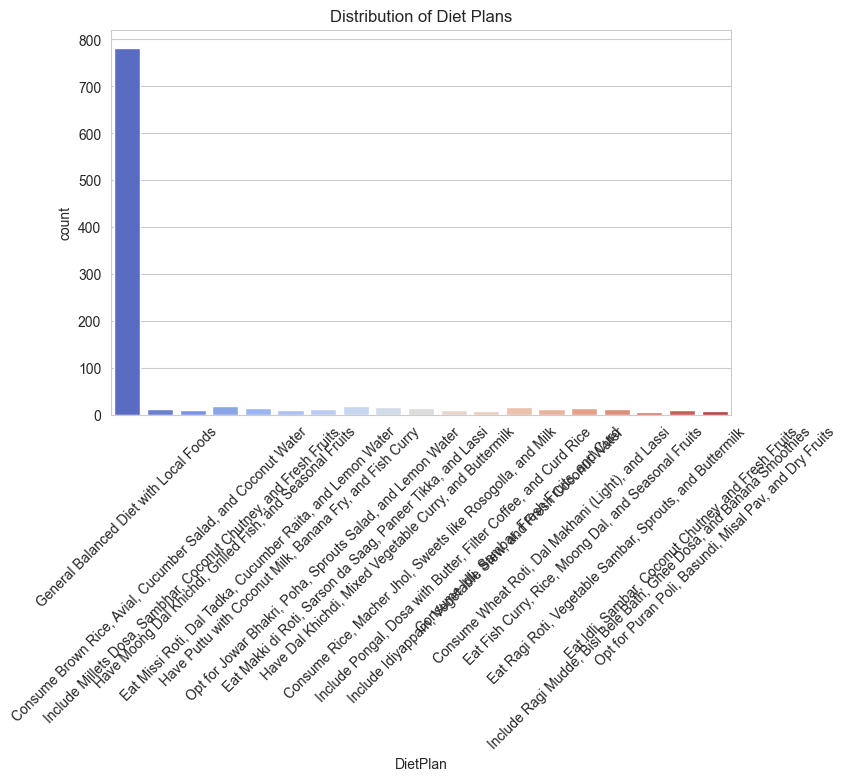

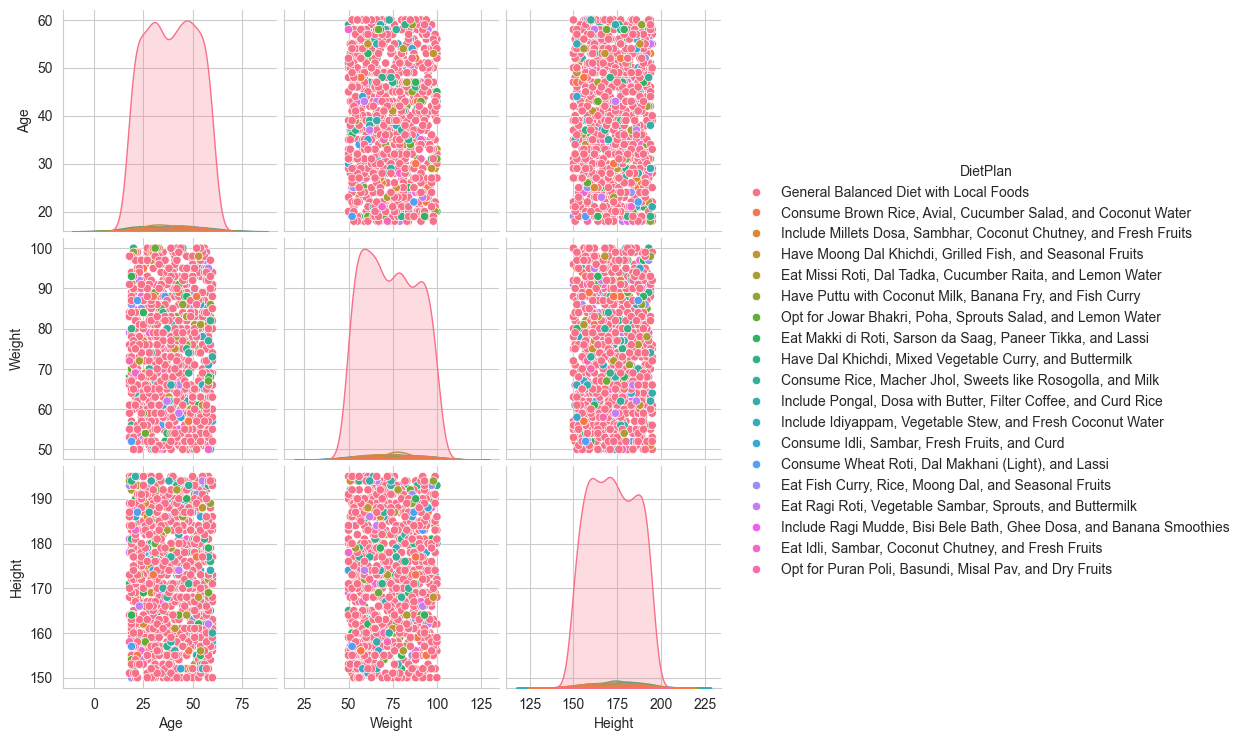

In [4]:

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Visualize distribution of target variable
plt.figure(figsize=(8, 5))
sns.countplot(x='DietPlan', data=df, palette="coolwarm")
plt.xticks(rotation=45)
plt.title("Distribution of Diet Plans")
plt.show()

# Pairplot to see relationships
sns.pairplot(df, hue="DietPlan")
plt.show()


### 🔗 Correlation Heatmap

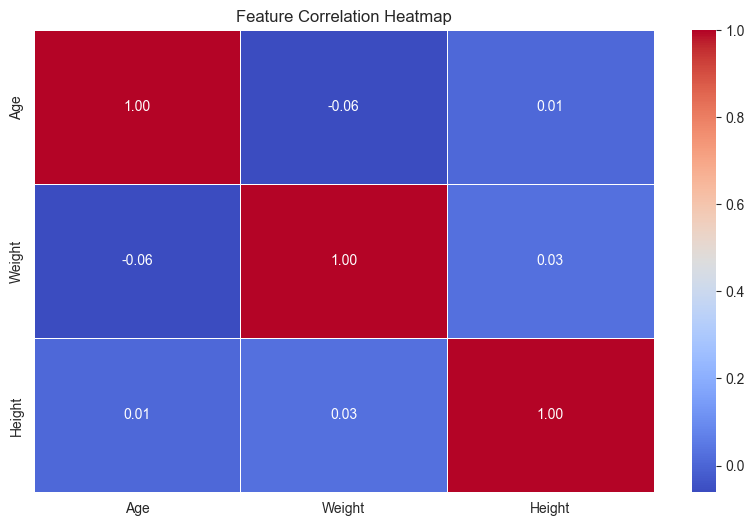

In [5]:
df_numeric = df.select_dtypes(include=["number"])  

plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


## 🛠 Data Preprocessing

In [6]:

# Encode categorical columns
label_encoders = {}
for col in ["Area", "Preference", "DietPlan"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target
X = df.drop(columns=["DietPlan"])
y = df["DietPlan"]

# Standardize numerical features
scaler = StandardScaler()
X[["Age", "Weight", "Height"]] = scaler.fit_transform(X[["Age", "Weight", "Height"]])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 🤖 Model Training & Evaluation

In [7]:

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Evaluate Models
rf_acc = accuracy_score(y_test, rf_pred)
xgb_acc = accuracy_score(y_test, xgb_pred)

print(f"✅ Random Forest Accuracy: {rf_acc:.4f}")
print(f"✅ XGBoost Accuracy: {xgb_acc:.4f}")


c:\Program Files\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:13:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ Random Forest Accuracy: 0.9000
✅ XGBoost Accuracy: 1.0000


## 🎯 Feature Importance Analysis

C:\Users\tanma\AppData\Local\Temp\ipykernel_10536\2735903010.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")


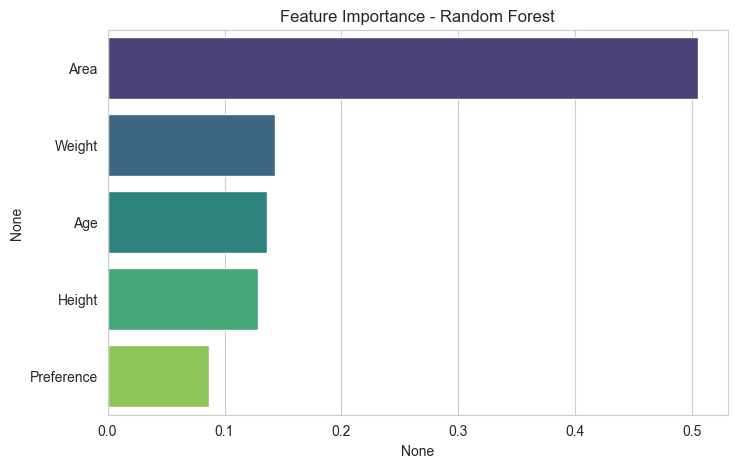

In [8]:

# Plot feature importance for Random Forest
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.show()


## ⚙️ Hyperparameter Tuning (GridSearchCV)

In [9]:

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

grid_search_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42), 
                               param_grid_xgb, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

print(f"🎯 Best Random Forest Accuracy: {grid_search_rf.best_score_:.4f}")
print(f"🎯 Best XGBoost Accuracy: {grid_search_xgb.best_score_:.4f}")


c:\Program Files\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:13:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🎯 Best Random Forest Accuracy: 0.8725
🎯 Best XGBoost Accuracy: 0.9912


## 💾 Save the Best Model

In [10]:

# Save best model
joblib.dump(best_xgb, "best_xgb_model.pkl")
print("✅ Best XGBoost Model Saved!")


✅ Best XGBoost Model Saved!
